In [2]:
# Basic building-block packages
import numpy as np
from numpy import heaviside as th

# For numerical solutions of ODEs
from scipy.integrate import solve_ivp

# Some fancy-smancy maths!! (not really)
from scipy.stats import linregress
from numpy.linalg import norm

# For pretty-pretty graphs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

# Quality of life shit
from tqdm import tqdm
import pickle

## Integration method 1

[0.0004581324179765894, 0.004545454545454545, 8.190818181818182] 
 [0.00030046913060475746, 4.545454545454545e-05, 1.1829130434782609]
Simulation of 0.02s.


100%|██████████| 3/3 [00:00<00:00,  6.87it/s]


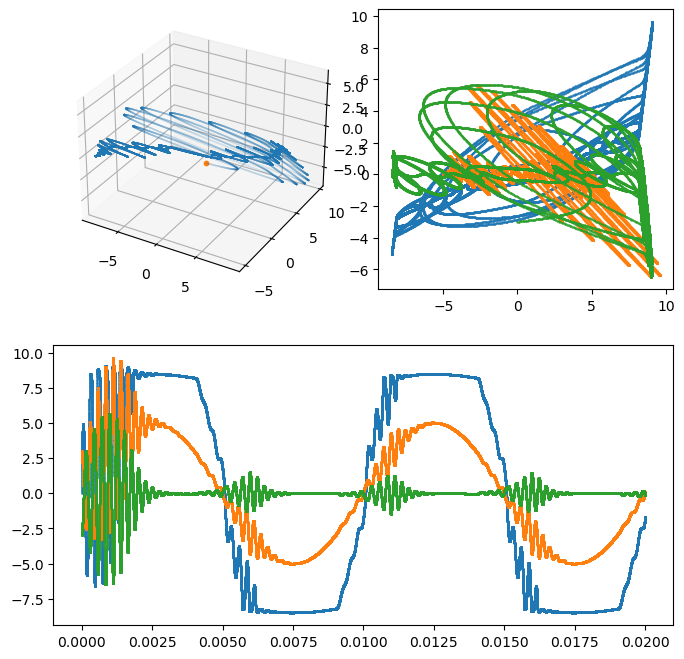

In [270]:
# Parameters 

R = 1410
C1 = 10e-9
C2 = 100e-9
L = 15e-3

R2,R3 = 220,2200
R4,R6 = 22000,3300
A = 1000; E = 9

F,freq = 5,100

interior = [((A-1)*R2+R3)/(R2*(R2+(1+A)*R3))
            ,1/R2,
            (R2+(1+A)*R3)/(A*(R2+R3))*E]
exterior = [((A-1)*R4+R6)/(R4*(R4+(1+A)*R6))
            ,1/R4
            ,(R4+(1+A)*R6)/(A*(R4+R6))*E]

print(interior,"\n",exterior)

def NIC(x,a,b,B):
    g = -a*x*(th(x+B,1)-th(x-B,1)) # Centre
    g += (b*x+(a+b)*B)*th(-x-B,1) # Lefterior
    g += (b*x-(a+b)*B)*th(x-B,1) # Righterior
    return g

def Chua(x,a1,b1,B1,a2,b2,B2):
    return NIC(x,a1,b1,B1)+NIC(x,a2,b2,B2)

# Numerical interation method 1

dt = 2e-7; duration = 1e5
print(f"Simulation of {dt*duration}s.")

X,Y,Z = [0],[3],[0]
for i in tqdm(range(int(duration))):
    t = i*dt

    xi,yi,zi = X[-1],Y[-1],Z[-1]

    dx = (yi-xi)/R-Chua(xi,*interior,*exterior)
    dy = (xi-yi)/R+zi
    dz = -yi+F*np.sin(2*np.pi*freq*t)
    # dz = -yi
    X.append(xi+dx/C1*dt);Y.append(yi+dy/C2*dt);Z.append(zi+dz/L*dt)

t = [t*dt for t in range(int(duration+1))]

Z = np.array(Z);t = np.array(t)
Z = (Z[:-1]-Z[1:])/(t[:-1]-t[1:])*L # Time differential
X = X[:-1]; Y = Y[:-1]; t = t[:-1]

# Plot the solutions

"""
If the plot that this code block shows is not pleasing for you, don't 
repeat the simulation in this code block, but instead move on to the b
lock below and use the code there to manipulate the data. 

- Kachow
"""

fig = plt.figure(figsize=(8,8))
grid = gs.GridSpec(2,2,wspace=0.1,)

axs1 = fig.add_subplot(grid[0,0], projection='3d')
axs2 = plt.subplot(grid[0,1])
axs3 = plt.subplot(grid[1,:])

axs1.scatter(X,Y,Z
               ,s=0.003
               )
axs1.scatter(X[0],Y[0],Z[0]
               ,s=10
               )

axs2.scatter(X,Y,s=0.3)
axs2.scatter(Y,Z,s=0.3)
axs2.scatter(X,Z,s=0.3)

for var in tqdm([X,Y,Z]):
    axs3.scatter(t, var,s=0.3)

Draw plots: 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]


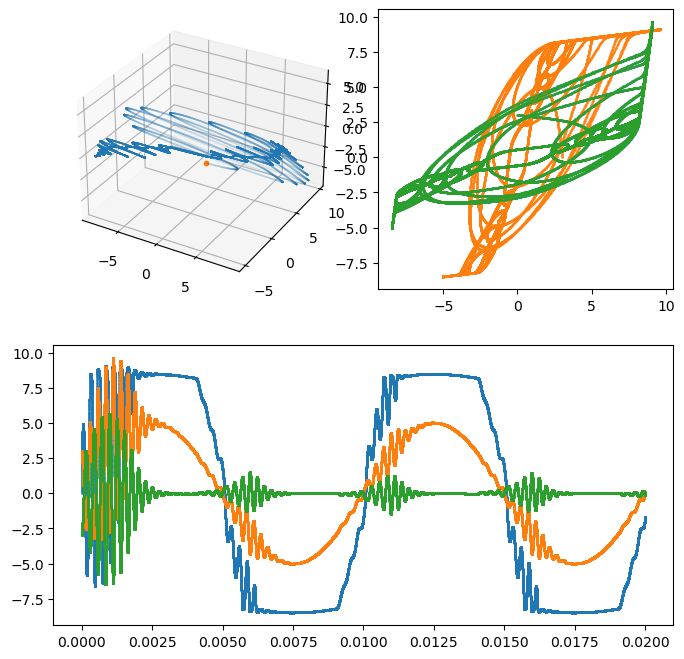

In [271]:
# Save the simulated data. 
"""
Select the code below and press "ctrl+/" to activate code block.
"""

# data = {"param": 
#         {"R":R,"C1":C1,"C2":C2,"L":L
#          ,"R2":R2,"R3":R3,"R4":R4,"R6":R6,"E":E
#          ,"F":F,"f":freq},
#          "simul": {"dt":dt,"dur":duration}
#          ,"X":X,"Y":Y,"Z":Z,"t":t}

# handle = open(f"sim_R{R}.pkl", 'wb')
# pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
# handle.close()

# Plot the data

ini = 0
end = int(len(Y))
spac = 100

Xspa = X[ini:end:spac]
Yspa = Y[ini:end:spac]
Zspa = Z[ini:end:spac]

fig = plt.figure(figsize=(8,8))
grid = gs.GridSpec(2,2,wspace=0.1,)

axs1 = fig.add_subplot(grid[0,0], projection='3d')
axs2 = plt.subplot(grid[0,1])
axs3 = plt.subplot(grid[1,:])

axs1.scatter(X,Y,Z
               ,s=0.003
               )
axs1.scatter(X[0],Y[0],Z[0]
               ,s=10
               )
data = [X,Y,Z]
for i in tqdm(range(3),desc="Draw plots"):
    axs2.scatter(data[i%2],data[(i+1)%2],s=0.3)
    axs3.scatter(t, data[i],s=0.3)

# ini = 0
# end = int(len(Y))
# spac = 100
# # plt.plot(X[::500],scaled[::500])
# plt.scatter(t[ini:end:spac],X[ini:end:spac],s=0.3)
# plt.scatter(t[ini:end:spac],Y[ini:end:spac],s=0.3)
# plt.scatter(t[ini:end:spac],Z[ini:end:spac],s=0.3)

## Integration method 2

by solve_ivp from scipy

In [4]:
# Numerical integration by solve_ivp

def NIC(x,a,b,B):
    g = -a*x*(th(x+B,1)-th(x-B,1)) # Centre
    g += (b*x+(a+b)*B)*th(-x-B,1) # Lefterior
    g += (b*x-(a+b)*B)*th(x-B,1) # Righterior
    return g

def Chua(x,a1,b1,B1,a2,b2,B2):
    return NIC(x,a1,b1,B1)+NIC(x,a2,b2,B2)

def sys_DE(t,w,inte,exte,circ):
    """
    Defines Chua's equations

    Arguments:
        w :  vector of the state variables:
                  w = [x,y,z]
        t :  time
        p :  vector of the parameters:
                  p = [m1,m2,k1,k2,L1,L2,b1,b2]
    """
    x,y,z = w
    R,C1,C2,L,F,freq = circ
    dx = ((y-x)/R-Chua(x,*inte,*exte))/C1
    dy = ((x-y)/R+z)/C2
    dz = -y/L-(F*np.sin(2*np.pi*freq*t))/L
    return dx,dy,dz

def standardise(x,y,z,t,step=1):
    z = ((z[:-1]-z[1:])/(t[:-1]-t[1:])*L)[::step]
    x = x[1::step]
    y = y[1::step]
    t = t[1::step]
    return x,y,z,t

def max_lyapunov(X1,X2):
    X1_0,X2_0 = X1[0],X2[0]

    dX = [x1-x2 for x1,x2 in zip(X1,X2)]
    dX = np.linalg.norm(dX,axis=0)

    dX0 = [X1-X2 for X1,X2 in zip(X1_0,X2_0)]
    dX0 = np.linalg.norm(dX0)

    y = dX/dX0
    t = data[0][3]

    fit = linregress(t,y)
    m = fit.slope
    b = fit.intercept
    corr = fit.rvalue
    return m,b,corr

########## End of function defining ##########

R = 2500
C1 = 10e-9
C2 = 100e-9
L = 15e-3

R2,R3 = 220,2200
R4,R6 = 22000,3300
A = 100; E = 9

F,freq = 0,1000

interior = [((A-1)*R2+R3)/(R2*(R2+(1+A)*R3))
            ,1/R2,
            (R2+(1+A)*R3)/(A*(R2+R3))*E]
exterior = [((A-1)*R4+R6)/(R4*(R4+(1+A)*R6))
            ,1/R4
            ,(R4+(1+A)*R6)/(A*(R4+R6))*E]
circ = [R,C1,C2,L,F,freq]

t_span = (0,10)
t_eval = np.linspace(*t_span,int(1e7)) # No need to be so fine like here. 
xyz0 = [0.2,.108,0.01] # Recall that z is in Amperes (a large unit).
solution = solve_ivp(sys_DE,t_span,xyz0,t_eval=t_eval,first_step=1e-7,
                     args=[interior,exterior,circ])

x_sol = solution.y[0]
y_sol = solution.y[1]
z_sol = solution.y[2]
time = solution.t

x_sol,y_sol,z_sol,time = standardise(x_sol,y_sol,z_sol,time)

# Plot the solutions

fig = plt.figure(figsize=(8,8))
grid = gs.GridSpec(2,2,wspace=0.1,)

axs1 = fig.add_subplot(grid[0,0], projection='3d')
axs2 = plt.subplot(grid[0,1])
axs3 = plt.subplot(grid[1,:])

axs1.scatter(x_sol[::10],y_sol[::10],z_sol[::10]
               ,s=0.003
               )

axs2.scatter(x_sol,y_sol,s=0.3)
axs2.scatter(y_sol,z_sol,s=0.3)
axs2.scatter(x_sol,z_sol,s=0.3)

for var in [x_sol,y_sol,z_sol]:
    axs3.scatter(time, var,s=0.3)

KeyboardInterrupt: 

## Lyapunov exponent

Retrieved from : https://arxiv.org/pdf/physics/0303077.pdf

Given two independent trajectories $X_1(t)$ and $X_2(t)$ of distinct
initial contiditions, $X_1(t_0)=X_0$, $X_2(t_0)=X_0+\delta X_0$, we can define the largest 
Lyapunov exponent as 

$||\delta X||=e^{\lambda_{max}t}||\delta X_0||$

where $||\cdot||$ is any definite norm.

100%|██████████| 10/10 [01:19<00:00,  7.98s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


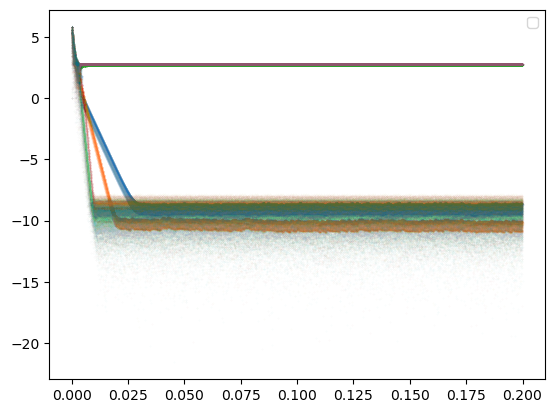

In [5]:
def max_lyapunov(X1,X2):
    X1_0,X2_0 = X1[0],X2[0]
    dX0 = np.linalg.norm(X1_0-X2_0)

    dX = [x1-x2 for x1,x2 in zip(X1,X2)]
    dX = np.linalg.norm(dX,axis=0)

    y = dX/dX0
    t = data[0][3]

    fit = linregress(t,y)
    m = fit.slope
    b = fit.intercept
    corr = fit.rvalue**2
    return y,m,b,corr

handle = open("collected_data/high_freq.pkl", 'rb')
data=pickle.load(handle)
handle.close()

freq = np.round(np.linspace(5e2,7.5e3,200),decimals=3) # High freq

lyau = []
for R in tqdm(np.linspace(2000,2600,10)):
    circ = [R,C1,C2,L,F,freq]

    data = []
    for X_0 in [X1_0,X2_0]:
        solution = solve_ivp(sys_DE,t_span,X_0,first_step=1e-7
                            ,args=[interior,exterior,circ]
                            ,t_eval=t_eval
                            )

        x1 = solution.y[0]
        y1 = solution.y[1]
        z1 = solution.y[2]
        t1 = solution.t

        data.append(np.array([x1,y1,z1,t1]))
    dX0 = norm(X1_0-X2_0)
    
    X1 = data[0][:3]
    X2 = data[1][:3]
    t = data[0][3]

    dX = norm(X1-X2,axis=0)
    y = np.log(dX/dX0)[:]

    # frc = int(len(y)/4)
    # t = t[:frc] ; y = y[:frc]

    fit = linregress(t,y)
    m = fit.slope
    b = fit.intercept
    corr = fit.rvalue**2
    
    lyau.append(y)

    plt.scatter(t,y,s=0.1,alpha=0.03)
    X = np.array([0,max(t)])
    # plt.plot(X,m*X+b,label=f"{round(R,ndigits=1)}")

plt.legend(loc="upper right")

In [272]:
X1,X2 = data[0][:3],data[1][:3]
t = data[0][3]

dX = [x1-x2 for x1,x2 in zip(X1,X2)]
dX = np.linalg.norm(dX,axis=0)

X1_0,X2_0 = X1[0],X2[0]
dX0 = np.linalg.norm(X1_0-X2_0)

y = np.log(dX/dX0)

fit = linregress(t,y)
m = fit.slope
b = fit.intercept
corr = fit.rvalue

y,m,b,coor = max_lyapunov(data[0][:3],data[1][:3])

print(m,coor)

plt.scatter(data[0][3],y,s=0.3)
X = np.array([0,max(t)])
plt.plot(X,m*X+b,color="orange")

TypeError: len() of unsized object

In [51]:
handle = open("collected_data/high_freq.pkl", 'rb')
data=pickle.load(handle)
handle.close()


freq = np.round(np.linspace(5e2,7.5e3,200),decimals=3) # High freq
amp = np.round(np.linspace(5e-2,2,75),decimals=3)

data1 = {}
for F in amp: 
    data1[F] = {}
    for f in freq:
        data1[F][f] = data[F][f][0]


1


# Lyapunov estimation from Rosenstein et al.

https://www.math.lsu.edu/clinic/4020clinic/GaitSP08/files/Rosenstein%20Lyapunov%20exponent.pdf

$n$ : dimension of the system

$m$ : embedding dimension, between Tarken's criterion and 2n. 

$N$ : number of points in time series

$J$ : lag reconstruction delay

In [126]:
import statsmodels.api as sm
from scipy.spatial.distance import cdist

freq = np.round(np.linspace(5e2,7.5e3,200),decimals=3) # High freq
amp = np.round(np.linspace(5e-2,2,75),decimals=3)

n = 3
m = 2*n+2 # >2n
N = len(data1[amp[0]][freq[0]][0])

t = data1[amp[0]][freq[0]][0]
dt = t[1]-t[0]
x = data1[amp[0]][freq[0]][1]

# Calculate lag
autocor = sm.tsa.acf(x)
J = np.argmin(autocor[autocor/autocor[0]>1-1/np.e])

M = N-(m-1)*J

# Create reconstructed trajectory
X = np.array([x[i:i+(m-1)*J] for i in range(M)])
X = X.T
time = np.array([t[i:i+(m-1)*J] for i in range(M)])
time = time.T

# Calculate mean period
spectrum = np.abs(np.fft.fft(x))
f_dominant = np.argmax(spectrum)/len(x)
T_mean = 1/f_dominant*dt

# Find nearest neighbor
msk = cdist(time,time,metric='euclidean') > T_mean

pair_norm = cdist(X, X, metric='euclidean')
# pair_norm[~msk]=np.nan
D0 = np.min(pair_norm, axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [128]:
print(min(pair_norm[~msk]))
print(D0)

0.0
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
